In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from importlib.util import find_spec

In [11]:
importlib.util.find_spec('nunpy')

In [14]:
_has_dash: bool = True if (find_spec('dash') and find_spec('kalido')) else False

In [15]:
_has_dash

False

In [9]:
_has_py4cyto

False

In [18]:
from pathlib import Path

In [20]:
curr_path = Path.cwd()

In [28]:
list(curr_path.glob('./lang_main_consdfig.toml'))

[]

In [27]:
pkg_dir = curr_path

In [36]:
pkg_dir

WindowsPath('A:/Arbeitsaufgaben/lang-main/notebooks')

In [44]:
list((pkg_dir/'home.py').parents)

[WindowsPath('A:/Arbeitsaufgaben/lang-main/notebooks'),
 WindowsPath('A:/Arbeitsaufgaben/lang-main'),
 WindowsPath('A:/Arbeitsaufgaben'),
 WindowsPath('A:/')]

In [40]:
cfg_found = False
for it in range(len(pkg_dir.parents)):
    search_path = pkg_dir.parents[it]
    res = tuple(search_path.glob(f'lang_main*.toml'))
    if res:
        cfg_found = True
        target = res[0]
        break
    if search_path.name == 'python':
        break

In [41]:
cfg_found

True

In [30]:
target

WindowsPath('A:/Arbeitsaufgaben/lang-main/lang_main_config.toml')

In [2]:
import py4cytoscape as p4c

In [3]:
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [5]:
p4c.cytoscape_api_versions()

['v1']

In [6]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [9]:
from lang_main import io
from lang_main.analysis.graphs import rescale_edge_weights, get_graph_metadata
from lang_main import model_loader
from lang_main.types import LanguageModels
from lang_main.constants import MODEL_LOADER_MAP
import lang_main.pipelines.predefined as pipes
import lang_main.render.cytoscape as cyto
from lang_main.analysis import graphs

from pathlib import Path
import pickle
import base64
import os
from logging import NullHandler
import time

import numpy as np
import networkx as nx

import py4cytoscape as p4c
#import py4cytoscape.py4cytoscape_logger_settings as p4c_logging
#p4c.set_summary_logger(False)
#p4c_logging._SUMMARY_LOG_LEVEL = 'ERROR'
# p4c_logging._DETAIL_LOG_LEVEL = 'ERROR'
#p4c.py4cytoscape_logger.detail_logger.setLevel('ERROR')
#p4c.py4cytoscape_logger.detail_logger.removeHandler(p4c.py4cytoscape_logger.detail_handler)
#p4c.py4cytoscape_logger.detail_logger.addHandler(NullHandler())

A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


2024-09-12 12:20:04 +0000 | lang_main:io:INFO | Loaded TOML config file successfully.


A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads 

In [25]:
results = r'A:\Arbeitsaufgaben\lang-main\scripts\results\test_20240807'
p_res = Path(results)

In [26]:
prefilter = 'TK-GRAPH_POSTPROCESSING.pkl'
postfilter = 'TK-GRAPH_ANALYSIS.pkl'

In [27]:
p_pre = p_res / prefilter
p_post = p_res / postfilter

In [28]:
assert p_pre.exists()
assert p_post.exists()

In [29]:
res_pre = io.load_pickle(p_pre)
res_post = io.load_pickle(p_post)

2024-09-12 12:33:10 +0000 | lang_main:io:INFO | Loaded file successfully.
2024-09-12 12:33:10 +0000 | lang_main:io:INFO | Loaded file successfully.


In [30]:
tkg_pre = res_pre[0]

In [31]:
tkg_post = res_post[0]

In [32]:
print(tkg_pre)
print(tkg_post)

TokenGraph(name: TokenGraph, number of nodes: 7024, number of edges: 25600)
TokenGraph(name: TokenGraph, number of nodes: 227, number of edges: 330)


In [21]:
BOUND = 30
tkg_filt = graphs.filter_graph_by_edge_weight(tkg_pre, bound_lower=BOUND, bound_upper=None)
tkg_filt = graphs.filter_graph_by_node_degree(tkg_filt, bound_lower=1, bound_upper=None)
tkg_filt

TokenGraph(name: TokenGraph, number of nodes: 351, number of edges: 603)

In [22]:
t1 = time.perf_counter_ns()
cyto.import_to_cytoscape(tkg_filt)
t2 = time.perf_counter_ns()
cyto.layout_network()
t3 = time.perf_counter_ns()
cyto.apply_style_to_network()
t4 = time.perf_counter_ns()
exec_time_whole = (t4 - t1) * 1e-9
exec_time_import = (t2 - t1) * 1e-9
exec_time_layout = (t3 - t2) * 1e-9
exec_time_style = (t4 - t3) * 1e-9
print(f'Exec time whole was {exec_time_whole:.6f} sec')
print(f'Exec time import was {exec_time_import:.6f} sec')
print(f'Exec time layout was {exec_time_layout:.6f} sec')
print(f'Exec time style was {exec_time_style:.6f} sec')

You are connected to Cytoscape!
Applying default style...
Applying preferred layout
Exec time whole was 9.541292 sec
Exec time import was 1.265542 sec
Exec time layout was 3.962870 sec
Exec time style was 4.312881 sec


In [22]:
render_pipe = pipes.build_tk_graph_render_pipe(with_subgraphs=True, export_folder=Path.cwd())

In [23]:
t1 = time.perf_counter_ns()
render_pipe.run((tkg_filt,))
t2 = time.perf_counter_ns()
exec_time_whole = (t2 - t1) * 1e-9
print(f'Exec time whole was {exec_time_whole:.6f} sec')

2024-09-12 12:21:28 +0000 | lang_main:base:INFO | Starting pipeline >>Graph_Static-Rendering<<...
You are connected to Cytoscape!
Applying default style...
Applying preferred layout
No nodes selected.
No nodes selected.
No nodes selected.
No nodes selected.
2024-09-12 12:21:42 +0000 | lang_main:io:INFO | Saved file successfully under A:\Arbeitsaufgaben\lang-main\notebooks\results\Pipe-Graph_Static-Rendering_Step-6_build_subnetworks.pkl
2024-09-12 12:21:42 +0000 | lang_main:base:INFO | Processing pipeline >>Graph_Static-Rendering<< successfully ended after 6 steps.
Exec time whole was 13.943395 sec


In [2]:
import pandas as pd
import seaborn as sns
sns.set()

In [3]:
record1 = [
    168, 203, 262, 351, 465, 726, 1122,
    1368, 1709, 2928
]
record2 = [
    225, 293, 405, 603, 857,
    1317, 2191, 2802, 3765, 7149
]
record3 = [
    12.94, 12.96, 13.55, 14.45, 15.39,
    17.64, 22.90, 26.95, 33.82, 61.75
]

In [4]:
data = {
    'nodes_num': record1,
    'edges_num': record2,
    'time_sec': record3,
}

In [5]:
df = pd.DataFrame.from_dict(data)
df

nodes_num  edges_num  time_sec
0        168        225     12.94
1        203        293     12.96
2        262        405     13.55
3        351        603     14.45
4        465        857     15.39
5        726       1317     17.64
6       1122       2191     22.90
7       1368       2802     26.95
8       1709       3765     33.82
9       2928       7149     61.75

<Axes: xlabel='nodes_num', ylabel='time_sec'>

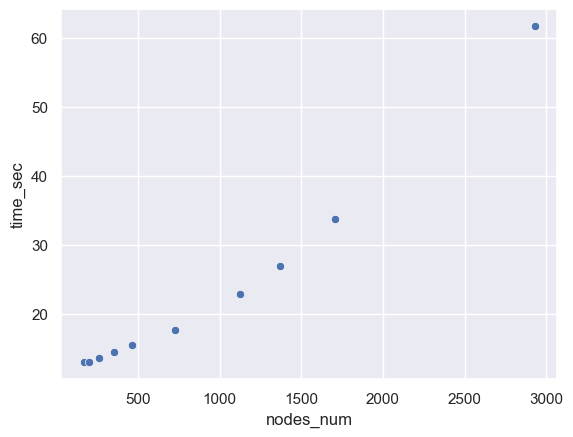

In [6]:
sns.scatterplot(data=df, x='nodes_num', y='time_sec')

<Axes: xlabel='edges_num', ylabel='time_sec'>

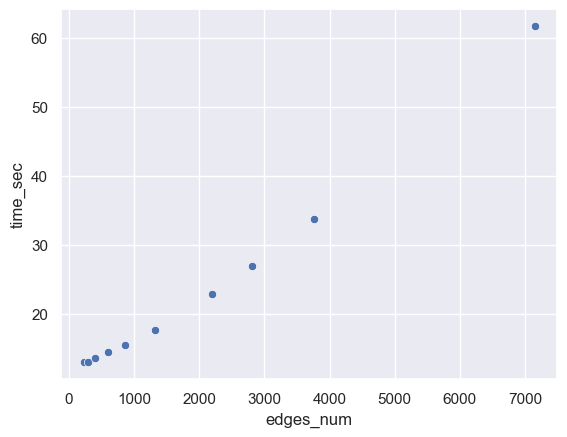

In [7]:
sns.scatterplot(data=df, x='edges_num', y='time_sec')

<Axes: xlabel='nodes_num', ylabel='edges_num'>

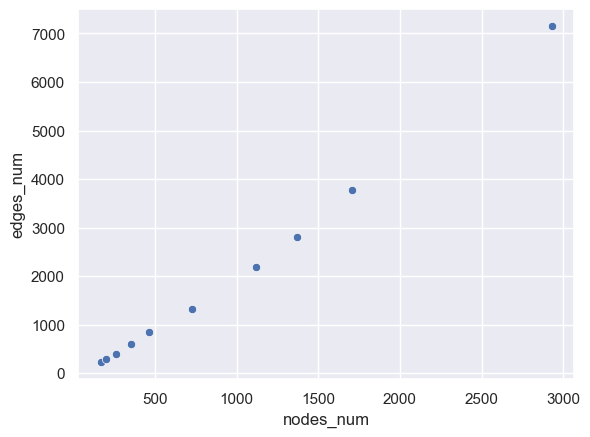

In [24]:
sns.scatterplot(data=df, x='nodes_num', y='edges_num')

In [13]:
import re

In [35]:
pattern = r'[(]+'
patt = re.compile(pattern)
pattern = r'[)]+'
patt2 = re.compile(pattern)

In [68]:
string = 'Test)1234 und anbei test2 (Änderung)'

In [69]:
string = patt.sub('\(', string)

In [71]:
string = patt2.sub('\)', string)

In [73]:
print(string)

Test\)1234 und anbei test2 \(Änderung\)


In [108]:
cyto.layout_network()

In [80]:
pre_c = tkg_pre.copy()
post_c = tkg_post.copy()

In [32]:
list(post_c.edges(data='weight'))[0][2]

92690

In [87]:
original = set(pre_c.edges(data='weight'))

In [88]:
ret = sorted(original, key=lambda tup: tup[2], reverse=True)

In [89]:
len(ret)

25600

In [90]:
chosen = set(ret[:300])

In [92]:
len(chosen)

300

In [94]:
drop = original.difference(chosen)

In [95]:
len(drop)

25300

In [96]:
tkg_test = tkg_pre.copy()

In [97]:
tkg_test.remove_edges_from(drop)

In [99]:
tkg_test = graphs.filter_graph_by_node_degree(tkg_test, bound_lower=1, bound_upper=None)

In [100]:
tkg_test

TokenGraph(name: TokenGraph, number of nodes: 210, number of edges: 300)

In [101]:
tkg_test.edges(data='weight')

OutEdgeDataView([('Wartungstätigkeit', 'Vorgabe', 92690), ('Wartungstätigkeit', 'Maschinenhersteller', 92690), ('Wartungstätigkeit', 'Maschinenbediener', 242), ('Wartungstätigkeit', 'Laserabteilung', 242), ('Wartungstätigkeit', 'Arbeitsplan', 244), ('Wartungstätigkeit', 'abarbeiten', 242), ('Vorgabe', 'Maschinenhersteller', 92690), ('Vorgabe', 'PLEVA', 1369), ('Vorgabe', 'Wartungsplan', 2210), ('Vorgabe', 'sehen', 1905), ('Vorgabe', 'Extradatum', 1905), ('Vorgabe', 'Firma', 730), ('Vorgabe', 'Menzel', 712), ('Vorgabe', 'Vorbelegung', 527), ('Überprüfung', 'Ölabscheider', 1622), ('Überprüfung', 'Leiter', 504), ('Überprüfung', 'Kompensator', 200), ('Überprüfung', 'Verschleiß', 200), ('Überprüfung', 'Dichtigkeit', 212), ('Überprüfung', 'Akku', 165), ('Überprüfung', 'Kran', 90), ('Sichtkontrolle', 'Reinigung', 3450), ('Reinigung', 'Bedarf', 280), ('Reinigung', 'Sichtkontrolle', 239), ('Reinigung', 'Einrichtung', 239), ('Reinigung', 'Luftdruckkontrolle', 239), ('Kontrolle', 'WC-Anlage', 126

In [63]:
s1 = {1,2,3}
s2 = {1,2,3,4,5,6}

In [64]:
s2.difference(s1)

{4, 5, 6}

In [2]:
model_loader.instantiate_model(MODEL_LOADER_MAP, LanguageModels.SPACY)

A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
res_path = Path(r'A:\Arbeitsaufgaben\lang-main\scripts\results\test_20240619')
assert res_path.exists()

In [4]:
#obj = 'TK-GRAPH_POSTPROCESSING.pkl'
obj = 'TK-GRAPH_ANALYSIS.pkl'
load_pth = res_path / obj
assert load_pth.exists()

In [5]:
ret = io.load_pickle(load_pth)

2024-07-24 06:14:16 +0000 | io:INFO | Loaded file successfully.


In [6]:
tkg = ret[0]

In [7]:
tkg

TokenGraph(name: TokenGraph, number of nodes: 158, number of edges: 192)

In [8]:
tkg.rescaled_weights

False

In [9]:
tkg.nodes['Wartungstätigkeit']

{'degree_weighted': 186350}

In [10]:
tkg.undirected.nodes['Wartungstätigkeit']

{'degree_weighted': 186350}

In [11]:
obj = 'TK-GRAPH_POSTPROCESSING.pkl'
# obj = 'TK-GRAPH_ANALYSIS.pkl'
load_pth = res_path / obj
assert load_pth.exists()

In [12]:
ret = io.load_pickle(load_pth)

2024-07-19 05:56:10 +0000 | io:INFO | Loaded file successfully.


In [13]:
tkg = ret[0]

In [14]:
tkg

TokenGraph(name: TokenGraph, number of nodes: 6859, number of edges: 25499)

In [15]:
tkg.rescaled_weights

False

In [16]:
directed, undirected = tkg.rescale_edge_weights()

In [17]:
directed.metadata_directed

{'num_nodes': 6859,
 'num_edges': 25499,
 'min_edge_weight': 0.0952,
 'max_edge_weight': 1.0,
 'node_memory': 433996,
 'edge_memory': 1427944,
 'total_memory': 1861940}

In [18]:
directed.metadata_undirected

{'num_nodes': 6859,
 'num_edges': 24796,
 'min_edge_weight': 1,
 'max_edge_weight': 92690,
 'node_memory': 433996,
 'edge_memory': 1388576,
 'total_memory': 1822572}

In [19]:
get_graph_metadata(undirected)

{'num_nodes': 6859,
 'num_edges': 24796,
 'min_edge_weight': 0.0952,
 'max_edge_weight': 1.0,
 'node_memory': 433996,
 'edge_memory': 1388576,
 'total_memory': 1822572}

break_early = False
i = 0
for idx, (node1, node2) in enumerate(list(Gtest.edges)):
    if break_early and i == 10:
        break
    Gtest[node1][node2]['weight'] = adjusted_weights[idx]
    
    i += 1

In [20]:
break_early = True
i = 0
for n1, n2, w in directed.edges.data('weight'):
    if break_early and i == 10:
        break
    print(n1, n2, w)

    i += 1

Wartungstätigkeit Vorgabe 1.0
Wartungstätigkeit Maschinenhersteller 1.0
Wartungstätigkeit Maschinenbediener 0.8215
Wartungstätigkeit Laserabteilung 0.8215
Wartungstätigkeit Arbeitsplan 0.8219
Wartungstätigkeit abarbeiten 0.8215
Wartungstätigkeit Webmaschinenkontrollliste 0.2534
Wartungstätigkeit sehen 0.2534
Vorgabe Maschinenhersteller 1.0
Vorgabe Wartungsplan 0.9181


In [21]:
break_early = True
i = 0
for n1, n2, w in undirected.edges.data('weight'):
    if break_early and i == 10:
        break
    print(n1, n2, w)

    i += 1

Wartungstätigkeit Vorgabe 1.0
Wartungstätigkeit Maschinenhersteller 1.0
Wartungstätigkeit sehen 0.2534
Wartungstätigkeit Maschinenbediener 0.8215
Wartungstätigkeit Laserabteilung 0.8215
Wartungstätigkeit Arbeitsplan 0.8219
Wartungstätigkeit abarbeiten 0.8215
Wartungstätigkeit Webmaschinenkontrollliste 0.2534
Vorgabe Maschinenhersteller 1.0
Vorgabe Wartungsplan 0.9181


---

# Load re-scaled Token Graph

In [6]:
#obj = 'TK-GRAPH_POSTPROCESSING.pkl'
obj = 'TK-GRAPH_ANALYSIS_RESCALED.pkl'
load_pth = res_path / obj
assert load_pth.exists()

In [7]:
ret = io.load_pickle(load_pth)

2024-07-24 06:14:31 +0000 | io:INFO | Loaded file successfully.


In [8]:
tk_resc = ret[1]

In [9]:
get_graph_metadata(tk_resc)

{'num_nodes': 158,
 'num_edges': 189,
 'min_edge_weight': 0.0952,
 'max_edge_weight': 1.0,
 'node_memory': 9908,
 'edge_memory': 10584,
 'total_memory': 20492}

In [97]:
break_early = True
n = 10

for idx, (node, weighted_degree) in enumerate(tk_resc.degree(weight='weight')):
    if break_early and idx == n:
        break
    print(node, weighted_degree)

Wartungstätigkeit 3.1190000474452972
Vorgabe 4.145399987697601
Maschinenhersteller 2.0
Sichtkontrolle 0.8227999806404114
Reinigung 1.7093999981880188
Überprüfung 2.0071999728679657
Ölabscheider 0.7318999767303467
Kontrolle 6.2471999898552895
C-Anlage 0.6929000020027161
Stabbreithalter 0.5758000016212463


In [312]:
dict(tk_resc.degree(weight='weight'))

{'Wartungstätigkeit': 3.1190000474452972,
 'Vorgabe': 4.145399987697601,
 'Maschinenhersteller': 2.0,
 'Sichtkontrolle': 0.8227999806404114,
 'Reinigung': 1.7093999981880188,
 'Überprüfung': 2.0071999728679657,
 'Ölabscheider': 0.7318999767303467,
 'Kontrolle': 6.2471999898552895,
 'C-Anlage': 0.6929000020027161,
 'Stabbreithalter': 0.5758000016212463,
 'Scharniere': 0.7002999782562256,
 '--': 0.7002999782562256,
 'Schließvorrichtung': 0.7059999704360962,
 'Schloß': 0.7059999704360962,
 'Kompressorstation': 0.5514000058174133,
 'Wasseraufbereitungsanlage': 0.5105999708175659,
 'Heizungsanlage': 0.5101000070571899,
 'Druckkontrolle': 1.140199989080429,
 'bar': 1.2935999631881714,
 'machen': 1.4854000210762024,
 'gegebenenfalls': 0.4934000074863434,
 'Filter': 0.4934000074863434,
 'sauber': 0.4986000061035156,
 'Leiter': 0.6482000052928925,
 'Analyse': 0.42980000376701355,
 'Kesselwasser': 0.42980000376701355,
 'überprüfen': 0.42980000376701355,
 'Wasserverbrauch': 0.42980000376701355,
 

In [98]:
nx.set_node_attributes(tk_resc, dict(tk_resc.degree(weight='weight')), name='weight_degree')

In [102]:
break_early = True
n = 10

for idx, node in enumerate(tk_resc.nodes):
    if break_early and idx == n:
        break
    print(tk_resc.nodes[node])

{'weight_degree': 3.1190000474452972}
{'weight_degree': 4.145399987697601}
{'weight_degree': 2.0}
{'weight_degree': 0.8227999806404114}
{'weight_degree': 1.7093999981880188}
{'weight_degree': 2.0071999728679657}
{'weight_degree': 0.7318999767303467}
{'weight_degree': 6.2471999898552895}
{'weight_degree': 0.6929000020027161}
{'weight_degree': 0.5758000016212463}


In [103]:
#import py4cytoscape as p4c
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [164]:
p4c.get_collection_list()

['lang_main']

In [25]:
p4c.networks.delete_all_networks()

''

In [182]:
p4c.networks.delete_network('test3')

''

In [208]:
p4c.networks.delete_all_networks()

''

In [209]:

p4c.create_network_from_networkx(tk_resc, title=BASE_NAME, collection='lang_main')

Applying default style...
Applying preferred layout


20743

In [210]:
p4c.tools.analyze_network(directed=False)

{'networkTitle': 'test (undirected)',
 'nodeCount': '158',
 'edgeCount': '189',
 'avNeighbors': '2.3684210526315788',
 'diameter': '10',
 'radius': '5',
 'avSpl': '3.7965860597439547',
 'cc': '0.3375',
 'density': '0.06401137980085347',
 'heterogeneity': '1.0891156226526975',
 'centralization': '0.38888888888888895',
 'ncc': '27',
 'time': '0.003'}

---

In [10]:
BASE_NETWORK_NAME = 'test'

def import_to_cytoscape(graph):
    p4c.networks.delete_all_networks()
    p4c.create_network_from_networkx(graph, title=BASE_NETWORK_NAME, collection='lang_main')
    p4c.tools.analyze_network(directed=False)


def reset_current_network_to_base():
    p4c.set_current_network(BASE_NETWORK_NAME)


def export_network_to_image(filename, filetype='SVG', network_name=BASE_NETWORK_NAME):
    target_folder = Path.cwd() / 'results'
    if not target_folder.exists():
        target_folder.mkdir(parents=True)
    file_pth = target_folder / filename

    text_as_font = True
    if filetype == 'SVG':
        text_as_font = False

    p4c.export_image(filename=str(file_pth), type=filetype, network=network_name, overwrite_file=True, all_graphics_details=True, export_text_as_font=text_as_font, page_size='A4')

In [11]:
LAYOUT_NAME = 'force-directed'
LAYOUT_PROPERTIES = {
    'numIterations': 1000,
    'defaultSpringCoefficient': 1e-4,
    'defaultSpringLength': 45,
    'defaultNodeMass': 11,
    'isDeterministic': True,
    'singlePartition': False,
}
PATH_STYLESHEET = Path('lang_main.xml')
STYLESHEET_NAME = 'lang_main'

def layout_network(layout_name=LAYOUT_NAME, layout_properties=LAYOUT_PROPERTIES, network_name=BASE_NETWORK_NAME):
    p4c.set_layout_properties(layout_name, layout_properties)
    p4c.layout_network(layout_name=layout_name, network=network_name)
    p4c.fit_content(selected_only=False, network=network_name)


def apply_style_to_network(pth_to_stylesheet=PATH_STYLESHEET, network_name=BASE_NETWORK_NAME):
    styles_avail = p4c.get_visual_style_names()
    if STYLESHEET_NAME not in styles_avail:
        p4c.import_visual_styles(pth_to_stylesheet)

    p4c.set_visual_style(STYLESHEET_NAME, network=network_name)
    p4c.fit_content(selected_only=False, network=network_name)

In [12]:
SELECTION_PROPERTY = 'node_selection'
SELECTION_NUMBER = 5
ITER_NEIGHBOUR_DEPTH = 2

def get_sub_node_selection(network_name=BASE_NETWORK_NAME):
    node_table = p4c.get_table_columns(network=network_name)
    node_table['stress_norm'] = node_table['Stress'] / node_table['Stress'].max()
    node_table[SELECTION_PROPERTY] = node_table['weight_degree'] * node_table['BetweennessCentrality'] * node_table['stress_norm']
    node_table = node_table.sort_values(by=SELECTION_PROPERTY, ascending=False)
    node_table_choice = node_table.iloc[:SELECTION_NUMBER,:]

    return node_table_choice['SUID'].to_list()


def select_neighbours_of_node(node, network_name=BASE_NETWORK_NAME):
    p4c.clear_selection(network=network_name)
    p4c.select_nodes(node, network=network_name)

    for _ in range(ITER_NEIGHBOUR_DEPTH):
        _ = p4c.select_first_neighbors(network=network_name)

    _ = p4c.select_edges_connecting_selected_nodes()


def make_subnetwork(index, network_name=BASE_NETWORK_NAME, export_image=True):
    subnetwork_name = network_name + f'_sub_{index+1}'
    p4c.create_subnetwork(nodes='selected', edges='selected', subnetwork_name=subnetwork_name, network=network_name)
    p4c.set_current_network(subnetwork_name)
    p4c.fit_content(selected_only=False, network=network_name)
    if export_image:
        export_network_to_image(filename=subnetwork_name, network_name=subnetwork_name)


def build_subnetworks(nodes_to_analyse, network_name=BASE_NETWORK_NAME, export_image=True):
    for idx, node in enumerate(nodes_to_analyse):
        select_neighbours_of_node(node=node, network_name=network_name)
        make_subnetwork(index=idx, network_name=network_name, export_image=export_image)

In [21]:
data = p4c.get_table_columns()

In [22]:
data['test2'] = data['degree_weighted'] * 1000

In [23]:
data

SUID       shared name              name  selected  \
257   257       anschreiben       anschreiben     False   
259   259  Erledigungsdatum  Erledigungsdatum     False   
261   261             Monat             Monat     False   
263   263       durchführen       durchführen     False   
265   265             Motor             Motor     False   
..    ...               ...               ...       ...   
247   247              Sitz              Sitz     False   
249   249  Wäscherkontrolle  Wäscherkontrolle     False   
251   251    Betriebsstunde    Betriebsstunde     False   
253   253           V-Röhre           V-Röhre     False   
255   255          Wechseln          Wechseln     False   

     AverageShortestPathLength  BetweennessCentrality  ClosenessCentrality  \
257                   1.750000               0.000000             0.571429   
259                   1.750000               0.000000             0.571429   
261                   4.945946               0.054054             0.202186   
263                   5.918919               0.000000             0.168950   
265                   1.000000               0.833333             1.000000   
..                         ...                    ...                  ...   
247                   3.000000               0.000000             0.333333   
249                   3.459459               0.000000             0.289062   
251                   1.500000               0.000000             0.666667   
253                   1.500000               0.000000             0.666667   
255                   1.000000               1.000000             1.000000   

     ClusteringCoefficient  Degree  Eccentricity  ...  \
257               0.000000       1             2  ...   
259               0.000000       1             2  ...   
261               0.000000       2             9  ...   
263               0.000000       1            10  ...   
265               0.166667       4             1  ...   
..                     ...     ...           ...  ...   
247               0.000000       1             5  ...   
249               1.000000       2             7  ...   
251               0.000000       1             2  ...   
253               0.000000       1             2  ...   
255               0.000000       2             1  ...   

     PartnerOfMultiEdgedNodePairs  Radiality  SelfLoops  Stress  \
257                             0   0.812500          0       0   
259                             0   0.812500          0       0   
261                             0   0.753378          0      72   
263                             0   0.692568          0       0   
265                             0   1.000000          0      10   
..                            ...        ...        ...     ...   
247                             0   0.666667          0       0   
249                             0   0.846284          0       0   
251                             0   0.750000          0       0   
253                             0   0.750000          0       0   
255                             0   1.000000          0       2   

     TopologicalCoefficient                id  degree_weighted  row.names  \
257                0.000000       anschreiben           0.2457        257   
259                0.000000  Erledigungsdatum           0.2457        259   
261                0.500000             Monat           0.4219        261   
263                0.000000       durchführen           0.2457        263   
265                0.500000             Motor           0.9828        265   
..                      ...               ...              ...        ...   
247                0.000000              Sitz           0.1580        247   
249                0.666667  Wäscherkontrolle           0.4914        249   
251                0.000000    Betriebsstunde           0.2524        251   
253                0.000000           V-Röhre           0.2524        253   
255                0.0

---

1. import network
2. layouting
3. apply styles
4. export image
5. build subgraphs
    1. get candidates
    2. build subnetwork
    3. export subnetwork

In [305]:
import_to_cytoscape(tk_resc)

Applying default style...
Applying preferred layout


In [306]:
layout_network()

In [307]:
apply_style_to_network()

In [308]:
export_network_to_image(filename=BASE_NETWORK_NAME)

In [309]:
nodes_to_analyse = get_sub_node_selection()

In [310]:
build_subnetworks(nodes_to_analyse=nodes_to_analyse, export_image=True)

No nodes selected.
No nodes selected.
No nodes selected.
No nodes selected.


In [40]:
data = p4c.get_table_columns()
data

SUID         shared name                name  selected  \
16385  16385         Fremdkörper         Fremdkörper     False   
16130  16130        Aschenbecher        Aschenbecher     False   
16388  16388            anfragen            anfragen     False   
16133  16133              leeren              leeren     False   
16391  16391              Termin              Termin     False   
...      ...                 ...                 ...       ...   
16121  16121     Wasserverbrauch     Wasserverbrauch     False   
16379  16379      Sicherstellung      Sicherstellung     False   
16124  16124           auffüllen           auffüllen     False   
16382  16382      Ausblasöffnung      Ausblasöffnung     False   
16127  16127  Desifektionsmittel  Desifektionsmittel     False   

                       id  degree_weighted  AverageShortestPathLength  \
16385         Fremdkörper           0.1257                   1.000000   
16130        Aschenbecher           0.7114                   1.333333   
16388            anfragen           0.4557                   1.000000   
16133              leeren           0.3557                   2.000000   
16391              Termin           0.4557                   1.000000   
...                   ...              ...                        ...   
16121     Wasserverbrauch           0.4298                   1.000000   
16379      Sicherstellung           0.1257                   1.000000   
16124           auffüllen           0.7114                   1.333333   
16382      Ausblasöffnung           0.1257                   1.000000   
16127  Desifektionsmittel           0.3557                   2.000000   

       ClusteringCoefficient  ClosenessCentrality  IsSingleNode  ...  Stress  \
16385                    0.0                 1.00         False  ...       0   
16130                    0.0                 0.75         False  ...       4   
16388                    0.0                 1.00         False  ...       0   
16133                    0.0                 0.50         False  ...       0   
16391                    0.0                 1.00         False  ...       0   
...                      ...                  ...           ...  ...     ...   
16121                    0.0                 1.00         False  ...       0   
16379                    0.0                 1.00         False  ...       0   
16124                    0.0                 0.75         False  ...       4   
16382                    0.0                 1.00         False  ...       0   
16127                    0.0                 0.50         False  ...       0   

       Degree  BetweennessCentrality  NeighborhoodConnectivity  \
16385       1               0.000000                       1.0   
16130       2               0.666667                       1.5   
16388       1               0.000000                       1.0   
16133       1               0.000000                       2.0   
16391       1               0.000000                       1.0   
...       ...                    ...                       ...   
16121       1               0.000000                       1.0   
16379       1               0.000000                       1.0   
16124       2               0.666667                       1.5   
16382       1               0.000000                       1.0   
16127       1               0.000000                       2.0   

       NumberOfDirectedEdges  NumberOfUndirectedEdges  Radiality  \
16385                      0                        1   1.000000   
16130                      0                        2   0.833333   
16388                      0                        1   1.000000   
16133                      0                        1   0.500000   
16391                      0                        1   1.000000   
...                      ...                      ...        ...   
16121                      0                        1   1.000000   
16379                      0            

In [41]:
min_val = data['node_selection'].min()
max_val = data['node_selection'].max()
print(f'{min_val=}, {max_val=}')

min_val=0.0, max_val=3.008924891341149


In [54]:
scheme = p4c.scheme_c_number_continuous(start_value=15, end_value=40)

In [55]:
node_size_map = p4c.gen_node_size_map('node_selection', number_scheme=scheme, mapping_type='c', style_name='lang_main', default_number=18)

In [56]:
node_size_map

{'table_column': 'node_selection',
 'table_column_values': [0.0, 1.5044624456705744, 3.008924891341149],
 'sizes': [15, 27.5, 40],
 'mapping_type': 'c',
 'default_size': 18,
 'style_name': 'lang_main',
 'network': None,
 'base_url': 'http://127.0.0.1:1234/v1'}

In [57]:
p4c.set_node_size_mapping(**node_size_map)

''

In [9]:
test = dict()

In [11]:
if not test:
    print('jo')

jo


In [12]:
from lang_main.render.cytoscape import layout_network

In [13]:
layout_network()

In [296]:
IDX = 0
nodes_to_select[IDX]

41497

In [297]:
select_neighbours_of_node(nodes_to_select[IDX])

In [300]:
build_subnetwork(IDX)

In [190]:
node_table = p4c.get_table_columns(network=BASE_NAME)

In [191]:
type(node_table)

pandas.core.frame.DataFrame

In [192]:
node_table.sort_values(by='Degree', ascending=False)

SUID           shared name                  name  selected  \
18610  18610             Kontrolle             Kontrolle     False   
18778  18778                  Herr                  Herr     False   
18799  18799                 Firma                 Firma     False   
18694  18694                 sehen                 sehen     False   
18712  18712             schmieren             schmieren     False   
...      ...                   ...                   ...       ...   
19048  19048                   E50                   E50     False   
19045  19045                    Öl                    Öl     False   
19042  19042  Rollenkette-zweifach  Rollenkette-zweifach     False   
19039  19039      Wechselintervall      Wechselintervall     False   
18943  18943                Menzel                Menzel     False   

                         id  weight_degree  AverageShortestPathLength  \
18610             Kontrolle         6.2472                   2.270270   
18778                  Herr         5.4802                   3.114286   
18799                 Firma         3.6372                   3.571429   
18694                 sehen         3.6508                   3.114286   
18712             schmieren         1.4378                   2.621622   
...                     ...            ...                        ...   
19048                   E50         0.1762                   4.243243   
19045                    Öl         0.1762                   1.000000   
19042  Rollenkette-zweifach         0.1762                   1.000000   
19039      Wechselintervall         0.1762                   1.000000   
18943                Menzel         0.5950                   4.542857   

       ClusteringCoefficient  ClosenessCentrality  IsSingleNode  ...  \
18610               0.025000             0.440476         False  ...   
18778               0.294872             0.321101         False  ...   
18799               0.127273             0.280000         False  ...   
18694               0.333333             0.321101         False  ...   
18712               0.066667             0.381443         False  ...   
...                      ...                  ...           ...  ...   
19048               0.000000             0.235669         False  ...   
19045               0.000000             1.000000         False  ...   
19042               0.000000             1.000000         False  ...   
19039               0.000000             1.000000         False  ...   
18943               0.000000             0.220126         False  ...   

       SelfLoops  Eccentricity  Stress  Degree  BetweennessCentrality  \
18610          0             5    1062      16               0.797297   
18778          1             6     962      15               0.402857   
18799          0             7    1328      11               0.401681   
18694          0             6    1034       7               0.281793   
18712          0             6     626       6               0.469970   
...          ...           ...     ...     ...                    ...   
19048          0             8       0       1               0.000000   
19045          0             1       0       1               0.000000   
19042          0             1       0       1               0.000000   
19039          0             1       0       1               0.000000   
18943          0             8       0       1               0.000000   

       NeighborhoodConnectivity  NumberOfDirectedEdges  \
18610                  1.812500                      0   
18778                  4.692308                      0   
18799                  2.818182                      0   
18694                  4.571429                      0   
18712                  4.333333                      0   
...                         ...                    ...   
19048                  4.000000                      0   
19045                  1.000000                      0   
19042                  1.0

---

In [193]:
node_table['stress_norm'] = node_table['Stress'] / node_table['Stress'].max()

In [194]:
node_table['w_deg with betweenness'] = node_table['weight_degree'] * node_table['BetweennessCentrality'] * node_table['stress_norm']

In [195]:
node_table_sorted = node_table.sort_values(by='w_deg with betweenness', ascending=False)

In [196]:
node_table_sorted.head()

SUID        shared name               name  selected  \
18610  18610          Kontrolle          Kontrolle     False   
18585  18585  Wartungstätigkeit  Wartungstätigkeit     False   
18778  18778               Herr               Herr     False   
18799  18799              Firma              Firma     False   
18592  18592            Vorgabe            Vorgabe     False   

                      id  weight_degree  AverageShortestPathLength  \
18610          Kontrolle         6.2472                   2.270270   
18585  Wartungstätigkeit         3.1190                   2.714286   
18778               Herr         5.4802                   3.114286   
18799              Firma         3.6372                   3.571429   
18592            Vorgabe         4.1454                   2.885714   

       ClusteringCoefficient  ClosenessCentrality  IsSingleNode  ...  Stress  \
18610               0.025000             0.440476         False  ...    1062   
18585               0.133333             0.368421         False  ...    1758   
18778               0.294872             0.321101         False  ...     962   
18799               0.127273             0.280000         False  ...    1328   
18592               0.400000             0.346535         False  ...    1106   

       Degree  BetweennessCentrality  NeighborhoodConnectivity  \
18610      16               0.797297                  1.812500   
18585       6               0.571429                  3.000000   
18778      15               0.402857                  4.692308   
18799      11               0.401681                  2.818182   
18592       5               0.315406                  4.600000   

       NumberOfDirectedEdges  NumberOfUndirectedEdges  Radiality  \
18610                      0                       16   0.920608   
18585                      0                        6   0.868132   
18778                      0                       14   0.837363   
18799                      0                       11   0.802198   
18592                      0                        5   0.854945   

       TopologicalCoefficient  stress_norm  w_deg with betweenness  
18610                0.091346     0.604096                3.008925  
18585                0.242424     1.000000                1.782286  
18778                0.329670     0.547213                1.208102  
18799                0.223140     0.755404                1.103640  
18592                0.383333     0.629124                0.822570  

[5 rows x 23 columns]

In [197]:
node_table_choice = node_table_sorted.iloc[:5,:]

In [198]:
node_table_choice

SUID        shared name               name  selected  \
18610  18610          Kontrolle          Kontrolle     False   
18585  18585  Wartungstätigkeit  Wartungstätigkeit     False   
18778  18778               Herr               Herr     False   
18799  18799              Firma              Firma     False   
18592  18592            Vorgabe            Vorgabe     False   

                      id  weight_degree  AverageShortestPathLength  \
18610          Kontrolle         6.2472                   2.270270   
18585  Wartungstätigkeit         3.1190                   2.714286   
18778               Herr         5.4802                   3.114286   
18799              Firma         3.6372                   3.571429   
18592            Vorgabe         4.1454                   2.885714   

       ClusteringCoefficient  ClosenessCentrality  IsSingleNode  ...  Stress  \
18610               0.025000             0.440476         False  ...    1062   
18585               0.133333             0.368421         False  ...    1758   
18778               0.294872             0.321101         False  ...     962   
18799               0.127273             0.280000         False  ...    1328   
18592               0.400000             0.346535         False  ...    1106   

       Degree  BetweennessCentrality  NeighborhoodConnectivity  \
18610      16               0.797297                  1.812500   
18585       6               0.571429                  3.000000   
18778      15               0.402857                  4.692308   
18799      11               0.401681                  2.818182   
18592       5               0.315406                  4.600000   

       NumberOfDirectedEdges  NumberOfUndirectedEdges  Radiality  \
18610                      0                       16   0.920608   
18585                      0                        6   0.868132   
18778                      0                       14   0.837363   
18799                      0                       11   0.802198   
18592                      0                        5   0.854945   

       TopologicalCoefficient  stress_norm  w_deg with betweenness  
18610                0.091346     0.604096                3.008925  
18585                0.242424     1.000000                1.782286  
18778                0.329670     0.547213                1.208102  
18799                0.223140     0.755404                1.103640  
18592                0.383333     0.629124                0.822570  

[5 rows x 23 columns]

In [199]:
nodes_to_select = node_table_choice['SUID'].to_list()

In [200]:
p4c.clear_selection()

''

In [239]:
p4c.select_nodes(nodes_to_select[0])

{}

In [202]:
iter_depth = 2

for _ in range(iter_depth):
    _ = p4c.select_first_neighbors()

In [203]:
_ = p4c.select_edges_connecting_selected_nodes()

In [206]:
p4c.create_subnetwork(nodes='selected', edges='selected', subnetwork_name='test_sub_1')

20402

In [205]:
p4c.fit_content(selected_only=False)

{}

In [314]:
sorted(list(p4c.get_layout_name_mapping().values()))

['attribute-circle',
 'attribute-grid',
 'attributes-layout',
 'circular',
 'cose',
 'degree-circle',
 'force-directed',
 'force-directed-cl',
 'fruchterman-rheingold',
 'grid',
 'hierarchical',
 'isom',
 'kamada-kawai',
 'stacked-node-layout']

In [186]:
p4c.get_layout_property_names('force-directed')

['numIterations',
 'defaultSpringCoefficient',
 'defaultSpringLength',
 'defaultNodeMass',
 'isDeterministic',
 'singlePartition']

In [259]:
LAYOUT_NAME = 'force-directed'
LAYOUT_PROPERTIES = {
    'numIterations': 1000,
    'defaultSpringCoefficient': 1e-4,
    'defaultSpringLength': 45,
    'defaultNodeMass': 11,
    'isDeterministic': True,
    'singlePartition': False,
}

In [188]:
p4c.set_layout_properties('force-directed', layout_props)
#p4c.get_layout_property_type('kamada-kawai', 'randomize')

''

In [189]:
p4c.layout_network(layout_name='force-directed', network='test3')

{}

In [ ]:
p4c.fit_content(selected_only=False)

In [34]:
# visual style gets always imported with increasing index,
# later check if style in Cytoscape is already available
styles_avail = p4c.get_visual_style_names()

In [35]:
if 'lang_main' not in styles_avail:
    p4c.import_visual_styles('lang_main.xml')

In [36]:
assert 'lang_main' in p4c.get_visual_style_names()

In [37]:
p4c.set_visual_style('lang_main')

{'message': 'Visual Style applied.'}

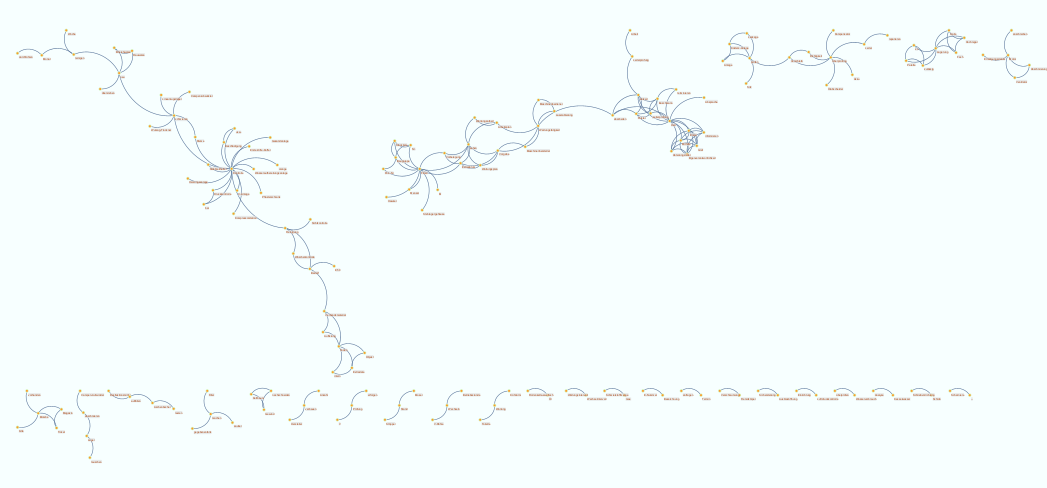

In [79]:
p4c.notebook_export_show_image()

- graph properties in Cytoscape or pre-calculated?
- node sizes depending on graph properties
- edge width depending on graph properties

---

# Py4Cytoscape

In [1]:
import py4cytoscape as p4c
#dir(p4c)
p4c.cytoscape_ping()
p4c.cytoscape_version_info()

You are connected to Cytoscape!


{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [2]:
import pandas as pd
nodes = pd.DataFrame(data={'id': ["node 0","node 1","node 2","node 3"], 'group': ["A","A","B","B"], 'score': [20,10,15,5]})
edges = pd.DataFrame(data={'source': ["node 0","node 0","node 0","node 2"], 'target': ["node 1","node 2","node 3","node 3"], 'interaction': ["inhibits","interacts","activates","interacts"], 'weight': [5.1,3.0,5.2,9.9]})

In [3]:
nodes

id group  score
0  node 0     A     20
1  node 1     A     10
2  node 2     B     15
3  node 3     B      5

In [4]:
edges

source  target interaction  weight
0  node 0  node 1    inhibits     5.1
1  node 0  node 2   interacts     3.0
2  node 0  node 3   activates     5.2
3  node 2  node 3   interacts     9.9

In [5]:
p4c.create_network_from_data_frames(nodes, edges, title="my first network", collection="DataFrame Example")

Applying default style...
Applying preferred layout


128

In [6]:
p4c.hide_all_panels()

In [10]:
p4c.set_network_zoom_bypass(1.5, bypass=False)

''

In [11]:
p4c.clear_network_zoom_bypass()

In cyrest_delete(): Bypass Visual Property does not exist: NETWORK_SCALE_FACTOR


CyError: In cyrest_delete(): Bypass Visual Property does not exist: NETWORK_SCALE_FACTOR

In [7]:
p4c.fit_content()

{}

In [8]:
zoom = p4c.get_network_zoom()
zoom

3.1950671670515094

In [63]:
zoom * 0.96

1.5660484088532423

In [64]:
p4c.set_network_zoom_bypass(zoom * 0.96, bypass=False)

''

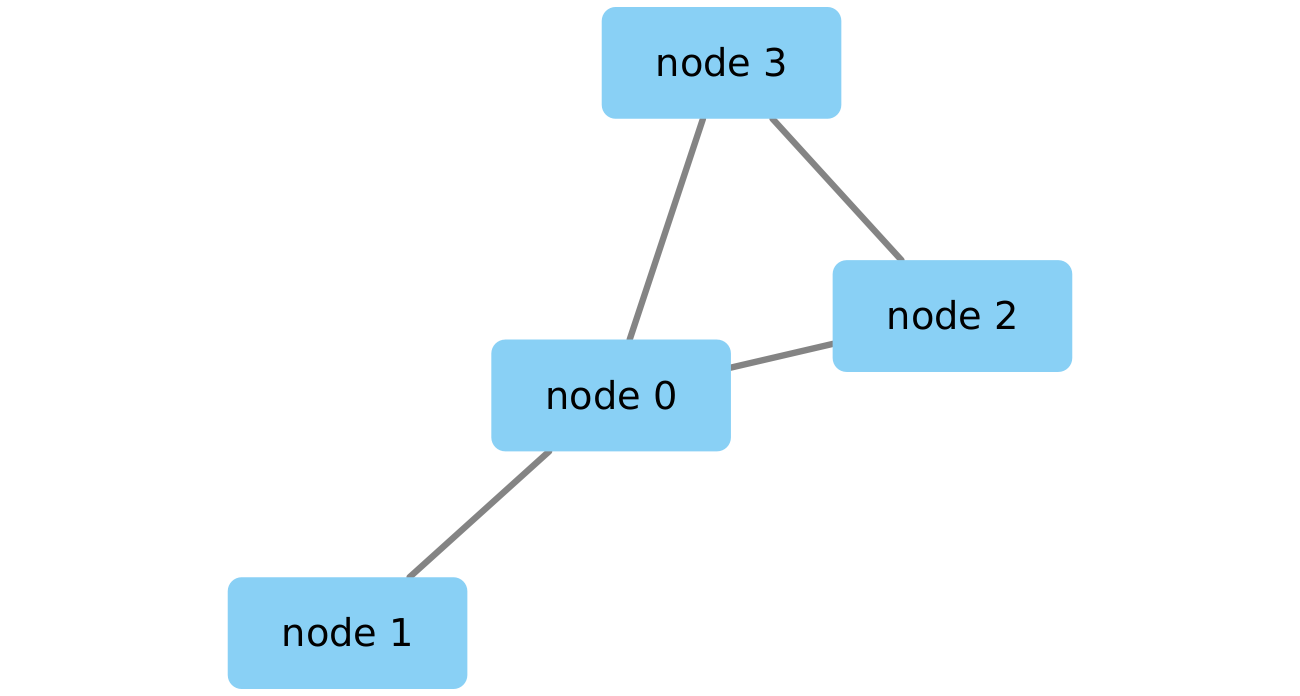

In [9]:
p4c.notebook_export_show_image()

In [12]:
p4c.set_visual_style('Marquee')

{'message': 'Visual Style applied.'}

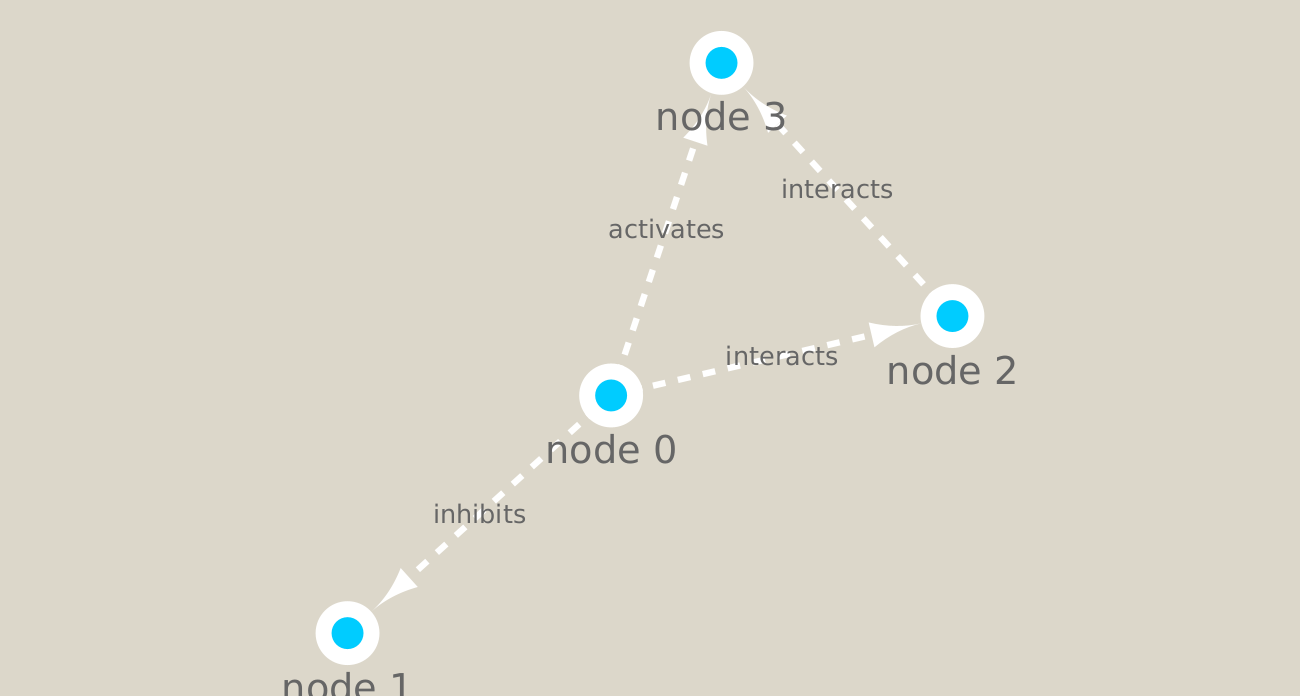

In [13]:
p4c.notebook_export_show_image()

In [14]:
style_name = "myStyle"
defaults = {'NODE_SHAPE': "diamond", 'NODE_SIZE': 30, 'EDGE_TRANSPARENCY': 120, 'NODE_LABEL_POSITION': "W,E,c,0.00,0.00"}
nodeLabels = p4c.map_visual_property('node label', 'id', 'p') #'p' means 'passthrough' mapping
edgeWidth = p4c.map_visual_property('edge width', 'weight', 'p') #'p' means 'passthrough' mapping
p4c.create_visual_style(style_name, defaults, [nodeLabels, edgeWidth])
p4c.set_visual_style(style_name)

{'message': 'Visual Style applied.'}

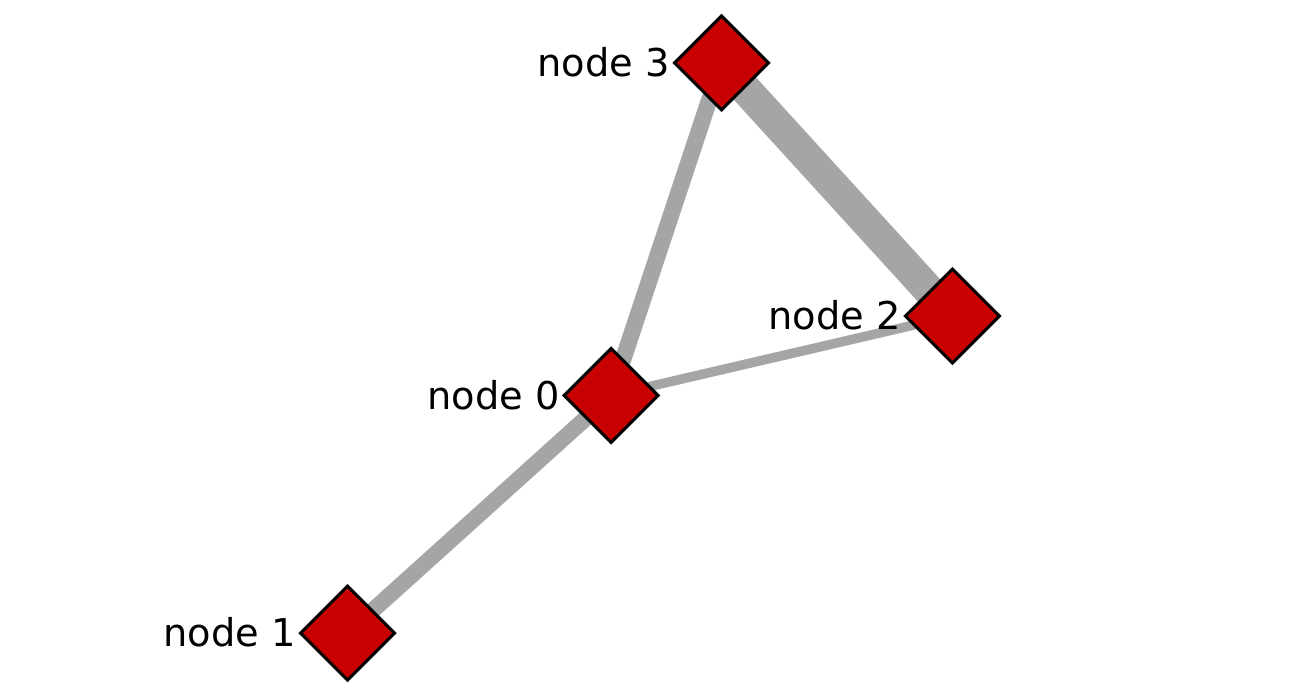

In [15]:
p4c.notebook_export_show_image()

In [20]:
nodes = pd.DataFrame(data={'id': ["A", "B", "C", "D"]})
edges = pd.DataFrame(data={'source': ["C", "B", "B", "B"], 'target': ["D", "A", "D", "C"]})

p4c.create_network_from_data_frames(nodes, edges, title="simple network", collection="Biological Example")

Applying default style...
Applying preferred layout


397

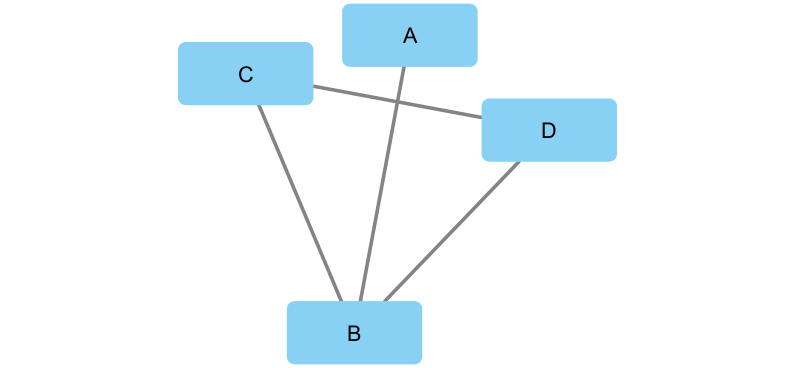

In [21]:
p4c.notebook_export_show_image()

In [22]:
p4c.get_table_columns()

SUID shared name id name  selected
427   427           A  A    A     False
430   430           B  B    B     False
433   433           C  C    C     False
436   436           D  D    D     False

In [23]:
p4c.get_table_column_names()

['SUID', 'shared name', 'id', 'name', 'selected']

In [25]:
p4c.get_layout_name_mapping()

{'Attribute Circle Layout': 'attribute-circle',
 'Stacked Node Layout': 'stacked-node-layout',
 'Attribute Grid Layout': 'attribute-grid',
 'Degree Sorted Circle Layout': 'degree-circle',
 'Circular Layout': 'circular',
 'Group Attributes Layout': 'attributes-layout',
 'Edge-weighted Spring Embedded Layout': 'kamada-kawai',
 'Prefuse Force Directed Layout': 'force-directed',
 'Compound Spring Embedder (CoSE)': 'cose',
 'Grid Layout': 'grid',
 'Hierarchical Layout': 'hierarchical',
 'Edge-weighted Force directed (BioLayout)': 'fruchterman-rheingold',
 'Inverted Self-Organizing Map Layout': 'isom',
 'Prefuse Force Directed OpenCL Layout': 'force-directed-cl'}

In [29]:
p4c.get_layout_property_names('kamada-kawai')

['m_averageIterationsPerNode',
 'm_nodeDistanceStrengthConstant',
 'm_nodeDistanceRestLengthConstant',
 'm_disconnectedNodeDistanceSpringStrength',
 'm_disconnectedNodeDistanceSpringRestLength',
 'm_anticollisionSpringStrength',
 'm_layoutPass',
 'singlePartition',
 'unweighted',
 'randomize']

In [31]:
p4c.get_layout_property_type('kamada-kawai', 'randomize')

'boolean'

In [32]:
p4c.get_layout_property_value('kamada-kawai', 'randomize')

True

In [34]:
from pathlib import Path

In [39]:
tp = Path.cwd()
file = tp / 'test.svg'

In [38]:
p4c.export_visual_styles(str(tp))

{'file': 'A:\\Arbeitsaufgaben\\lang-main\\test-notebooks.xml'}

In [40]:
p4c.export_image(str(file), type='SVG')

{'file': 'A:\\Arbeitsaufgaben\\lang-main\\test-notebooks\\test.svg'}

---

# Find reason that TokenGraph weight sometimes is zero

In [1]:
from lang_main.constants import SAVE_PATH_FOLDER, SPCY_MODEL
from lang_main.types import EntryPoints
from lang_main import io
from lang_main.analysis import tokens, graphs

2024-07-24 14:22:25 +0000 | io:INFO | Loaded TOML config file successfully.


A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytre

In [2]:
p_df = io.get_entry_point(SAVE_PATH_FOLDER, EntryPoints.TIMELINE)
(data,) = io.load_pickle(p_df)

2024-07-24 14:22:30 +0000 | io:INFO | Loaded file successfully.


In [3]:
data.head()

VorgangsID  ObjektID                     HObjektText  ObjektArtID  \
0          53       244  285 C, Webmaschine, SG 220 EMS            5   
1          58       257    107, Webmaschine, OM 220 EOS            3   
2          81       138        00138, Schärmaschine 9,            16   
3          82         0            Warenschau allgemein            0   
4          76         0                  Neben der Türe            0   

         ObjektArtText  VorgangsTypID            VorgangsTypName  \
0  Greifer-Webmaschine              3  Reparaturauftrag (Portal)   
1     Luft-Webmaschine              3  Reparaturauftrag (Portal)   
2        Schärmaschine              3  Reparaturauftrag (Portal)   
3                  NaN              3  Reparaturauftrag (Portal)   
4                  NaN              3  Reparaturauftrag (Portal)   

  VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  \
0    2019-03-19                 5                   0   
1    2019-03-21                 5                   0   
2    2019-03-25                 5                   0   
3    2019-03-25                 5                   0   
4    2019-03-22                 5                   0   

                       VorgangsBeschreibung           VorgangsOrt  \
0                         Kupplung schleift                   NaN   
1             Gegengewicht wieder anbringen                   NaN   
2  da ist etwas gebrochen. (Herr Heininger)                   NaN   
3          Klappbügel Portalkran H31 defekt  Warenschau allgemein   
4                      Schraube nix mer gut        Neben der Türe   

                                     VorgangsArtText ErledigungsDatum  \
0                                    Kupplung defekt       2019-03-20   
1         Gegengewicht an der Webmaschine abgefallen       2019-03-21   
2  zentrale Bremsenverstellung linke Gatterseite ...       2019-03-25   
3                      Allgemeine Reparaturarbeiten        2019-03-25   
4                                           Kettbaum       2019-03-25   

  ErledigungsArtText                            ErledigungsBeschreibung  \
0      Reparatur UTT                                                NaN   
1      Reparatur UTT  Schraube ausgebohrt\nGegengewicht wieder angeb...   
2      Reparatur UTT  Bolzen gebrochen. Bolzen neu angefertig und di...   
3      Reparatur UTT                                 Feder ausgetauscht   
4      Reparatur UTT  Schrauben ausgebohrt\t\nGewinde nachgeschnitten\t   

  MPMelderArbeitsplatz MPAbteilungBezeichnung Arbeitsbeginn ErstellungsDatum  
0              Weberei                Weberei           NaT       2019-03-19  
1              Weberei                Weberei    2019-03-21       2019-03-21  
2              Vorwerk                Vorwerk    2019-03-25       2019-03-25  
3           Warenschau             Warenschau    2019-03-25       2019-03-25  
4              Vorwerk                Vorwerk    2019-03-25       2019-03-22

In [4]:
p_tl = io.get_entry_point(SAVE_PATH_FOLDER, EntryPoints.TIMELINE_POST)
cands, texts = io.load_pickle(p_tl)

2024-07-24 14:22:30 +0000 | io:INFO | Loaded file successfully.


In [5]:
cands[1654][1]

(7552,
 8192,
 119558,
 647,
 2310,
 48781,
 66323,
 8214,
 5405,
 108961,
 91173,
 2985,
 3881,
 9917,
 66751,
 85442,
 118602,
 7243,
 62416,
 979,
 214,
 103,
 123111,
 81133,
 88558,
 14319,
 14834,
 2424,
 101497,
 25341,
 69375)

In [6]:
def pre_filter_data(
    data,
    idx,
    obj_id,
):
    idx = int(idx)
    obj_id = int(obj_id)
    # data = data.copy()
    cands_for_obj_id = cands[obj_id]
    cands_choice = cands_for_obj_id[int(idx) - 1]
    # data
    data = data.loc[list(cands_choice)].sort_index()  # type: ignore

    return data

In [14]:
# filtered = pre_filter_data(data, 2, 1654)
# filtered = pre_filter_data(data, 1, 1809)
filtered = pre_filter_data(data, 1, 59)

In [15]:
filtered

VorgangsID  ObjektID  \
188         139361        59   
6096        151017        59   
10470       587652        59   
53974       260534        59   
107542      531473        59   
122411      513489        59   

                                              HObjektText  ObjektArtID  \
188     514 C , Webmaschine, DL 280 EMS Breite 280 Bj....            3   
6096    514 C , Webmaschine, DL 280 EMS Breite 280 Bj....            3   
10470   514 C , Webmaschine, DL 280 EMS Breite 280 Bj....            3   
53974   514 C , Webmaschine, DL 280 EMS Breite 280 Bj....            3   
107542  514 C , Webmaschine, DL 280 EMS Breite 280 Bj....            3   
122411  514 C , Webmaschine, DL 280 EMS Breite 280 Bj....            3   

           ObjektArtText  VorgangsTypID            VorgangsTypName  \
188     Luft-Webmaschine              3  Reparaturauftrag (Portal)   
6096    Luft-Webmaschine              3  Reparaturauftrag (Portal)   
10470   Luft-Webmaschine              3  Reparaturauftrag (Portal)   
53974   Luft-Webmaschine              3  Reparaturauftrag (Portal)   
107542  Luft-Webmaschine              3  Reparaturauftrag (Portal)   
122411  Luft-Webmaschine              3  Reparaturauftrag (Portal)   

       VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  \
188       2021-09-16                 5                   0   
6096      2022-02-10                 5                   0   
10470     2023-06-13                 5                   0   
53974     2022-06-15                 5                   0   
107542    2023-05-08                 5                   0   
122411    2023-02-15                 5                   0   

              VorgangsBeschreibung VorgangsOrt            VorgangsArtText  \
188     Stab muss getauscht werden         NaN  Stabbreithalter Reparatur   
6096          Stab wurde getauscht         NaN  Stabbreithalter Reparatur   
10470         Stab wurde getauscht         NaN  Stabbreithalter Reparatur   
53974         Stab wurde getauscht         NaN  Stabbreithalter Reparatur   
107542        Stab wurde getauscht         NaN  Stabbreithalter Reparatur   
122411        Stab wurde getauscht         NaN  Stabbreithalter Reparatur   

       ErledigungsDatum       ErledigungsArtText  \
188          2021-09-15  Intern UTT - Reparatur    
6096         2022-02-10  Intern UTT - Reparatur    
10470        2023-06-13  Intern UTT - Reparatur    
53974        2022-06-15  Intern UTT - Reparatur    
107542       2023-05-08  Intern UTT - Reparatur    
122411       2023-02-15  Intern UTT - Reparatur    

                                  ErledigungsBeschreibung  \
188                                         UTT-Reparatur   
6096                                 Stab wurde getauscht   
10470                                Stab wurde getauscht   
53974                                Stab wurde getauscht   
107542  Sichtkontrolle durchgeführt\nstab wurde getaus...   
122411                               Stab wurde getauscht   

       MPMelderArbeitsplatz MPAbteilungBezeichnung Arbeitsbeginn  \
188                 Weberei                Weberei    2021-09-15   
6096                Weberei                Weberei    2022-02-10   
10470               Weberei                Weberei    2023-06-13   
53974               Weberei                Weberei    2022-06-15   
107542              Weberei                Weberei    2023-05-08   
122411              Weberei                Weberei    2023-02-15   

       ErstellungsDatum  
188          2021-09-16  
6096         2022-02-10  
10470        2023-06-13  
53974        2022-06-15  
107542       2023-05-08  
122411       2023-02-15

In [10]:
filtered.columns

Index(['VorgangsID', 'ObjektID', 'HObjektText', 'ObjektArtID', 'ObjektArtText',
       'VorgangsTypID', 'VorgangsTypName', 'VorgangsDatum', 'VorgangsStatusId',
       'VorgangsPrioritaet', 'VorgangsBeschreibung', 'VorgangsOrt',
       'VorgangsArtText', 'ErledigungsDatum', 'ErledigungsArtText',
       'ErledigungsBeschreibung', 'MPMelderArbeitsplatz',
       'MPAbteilungBezeichnung', 'Arbeitsbeginn', 'ErstellungsDatum'],
      dtype='object')

In [11]:
filtered['delta'] = filtered['ErledigungsDatum'] - filtered['ErstellungsDatum']
filtered['delta'] = filtered['delta'].dt.days

In [70]:
import plotly.express as px

In [114]:
MARKERS = {
    'size': 8,
    'color': 'red',
    'symbol': 'cross',
}

In [115]:
HOVER_DATA_DELTA = {
    'ErstellungsDatum': '|%d.%m.%Y',
    'ErledigungsDatum': '|%d.%m.%Y',
    'VorgangsDatum': '|%d.%m.%Y',
    'delta': True,
    'VorgangsBeschreibung': True,
}

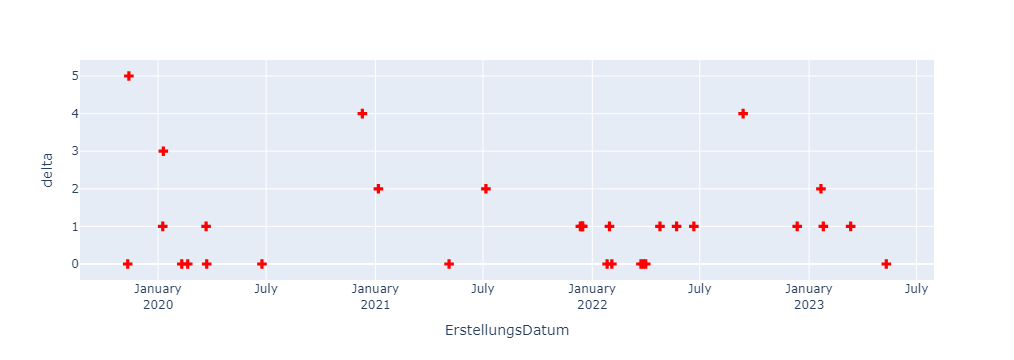

In [116]:
fig = px.scatter(filtered, x='ErstellungsDatum', y='delta', hover_data=HOVER_DATA_DELTA)
#fig = px.timeline(filtered, x_start='ErstellungsDatum', x_end='ErledigungsDatum', y='VorgangsID')
fig.update_traces(marker=MARKERS)
fig.update_xaxes(tickformat='%B\n%Y')
#fig.update_yaxes(type='category')
fig.update_yaxes(dtick=1)
fig.update_layout(hovermode='x unified')

In [129]:
scatt = go.Scatter(x=filtered['ErstellungsDatum'], y=filtered['delta'])

In [ ]:
scatt.update

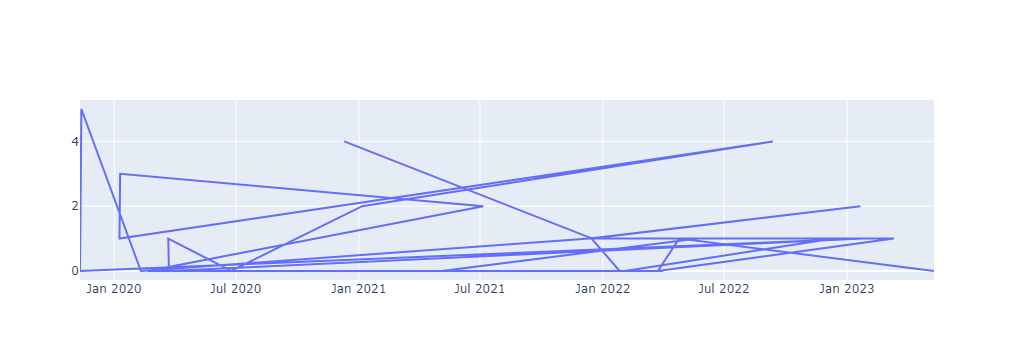

In [130]:
fig = go.Figure()
fig.add_trace(scatt)
fig.show()

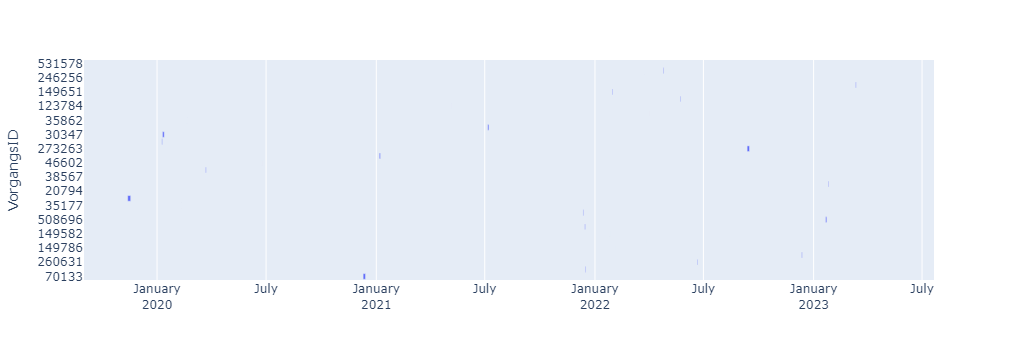

In [117]:
#fig = px.scatter(filtered, x='ErstellungsDatum', y='delta')
fig = px.timeline(filtered, x_start='ErstellungsDatum', x_end='ErledigungsDatum', y='VorgangsID')
fig.update_xaxes(tickformat='%B\n%Y')
fig.update_yaxes(type='category')
#fig.update_yaxes(tickformat=',d', dtick=1)

---

# Wertigkeit von Maßnahmen

In [1]:
from lang_main import io
from lang_main.analysis.graphs import rescale_edge_weights, get_graph_metadata
from lang_main.types import EntryPoints
from lang_main.constants import SAVE_PATH_FOLDER
from lang_main.analysis.shared import entry_wise_cleansing

from pathlib import Path
import pickle
import base64
import os
from logging import NullHandler

import numpy as np
import networkx as nx

import py4cytoscape as p4c
#import py4cytoscape.py4cytoscape_logger_settings as p4c_logging
#p4c.set_summary_logger(False)
#p4c_logging._SUMMARY_LOG_LEVEL = 'ERROR'
# p4c_logging._DETAIL_LOG_LEVEL = 'ERROR'
#p4c.py4cytoscape_logger.detail_logger.setLevel('ERROR')
#p4c.py4cytoscape_logger.detail_logger.removeHandler(p4c.py4cytoscape_logger.detail_handler)
#p4c.py4cytoscape_logger.detail_logger.addHandler(NullHandler())

2024-07-31 10:35:55 +0000 | io:INFO | Loaded TOML config file successfully.


A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
A:\Arbeitsaufgaben\lang-main\.venv\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytre

In [2]:
from lang_main.analysis.timeline import filter_timeline_cands, cleanup_descriptions, calc_delta_to_next_failure

In [3]:
p_df = io.get_entry_point(SAVE_PATH_FOLDER, EntryPoints.TIMELINE_POST)
# p_df = io.get_entry_point(SAVE_PATH_FOLDER, EntryPoints.TIMELINE)
(data,) = io.load_pickle(p_df)
# p_tl = Path(r'../results/test_20240619/TIMELINE_POSTPROCESSING.pkl').resolve()
p_tl = io.get_entry_point(SAVE_PATH_FOLDER, EntryPoints.TIMELINE_CANDS)
cands, texts = io.load_pickle(p_tl)

2024-07-31 10:36:04 +0000 | io:INFO | Loaded file successfully.
2024-07-31 10:36:04 +0000 | io:INFO | Loaded file successfully.


In [4]:
data.columns

Index(['VorgangsID', 'ObjektID', 'HObjektText', 'ObjektArtID', 'ObjektArtText',
       'VorgangsTypID', 'VorgangsTypName', 'VorgangsDatum', 'VorgangsStatusId',
       'VorgangsPrioritaet', 'VorgangsBeschreibung', 'VorgangsOrt',
       'VorgangsArtText', 'ErledigungsDatum', 'ErledigungsArtText',
       'ErledigungsBeschreibung', 'MPMelderArbeitsplatz',
       'MPAbteilungBezeichnung', 'Arbeitsbeginn', 'ErstellungsDatum',
       'delta_to_repair'],
      dtype='object')

In [5]:
data.head()

VorgangsID  ObjektID                     HObjektText  ObjektArtID  \
0          53       244  285 C, Webmaschine, SG 220 EMS            5   
1          58       257    107, Webmaschine, OM 220 EOS            3   
2          81       138        00138, Schärmaschine 9,            16   
3          82         0            Warenschau allgemein            0   
4          76         0                  Neben der Türe            0   

         ObjektArtText  VorgangsTypID            VorgangsTypName  \
0  Greifer-Webmaschine              3  Reparaturauftrag (Portal)   
1     Luft-Webmaschine              3  Reparaturauftrag (Portal)   
2        Schärmaschine              3  Reparaturauftrag (Portal)   
3                  NaN              3  Reparaturauftrag (Portal)   
4                  NaN              3  Reparaturauftrag (Portal)   

  VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  ...  \
0    2019-03-19                 5                   0  ...   
1    2019-03-21                 5                   0  ...   
2    2019-03-25                 5                   0  ...   
3    2019-03-25                 5                   0  ...   
4    2019-03-22                 5                   0  ...   

            VorgangsOrt                                    VorgangsArtText  \
0                   NaN                                    Kupplung defekt   
1                   NaN         Gegengewicht an der Webmaschine abgefallen   
2                   NaN  zentrale Bremsenverstellung linke Gatterseite ...   
3  Warenschau allgemein                      Allgemeine Reparaturarbeiten    
4        Neben der Türe                                           Kettbaum   

  ErledigungsDatum ErledigungsArtText  \
0       2019-03-20      Reparatur UTT   
1       2019-03-21      Reparatur UTT   
2       2019-03-25      Reparatur UTT   
3       2019-03-25      Reparatur UTT   
4       2019-03-25      Reparatur UTT   

                             ErledigungsBeschreibung MPMelderArbeitsplatz  \
0                                               N.V.              Weberei   
1  Schraube ausgebohrt. Gegengewicht wieder angeb...              Weberei   
2  Bolzen gebrochen. Bolzen neu angefertig und di...              Vorwerk   
3                                 Feder ausgetauscht           Warenschau   
4     Schrauben ausgebohrt . Gewinde nachgeschnitten              Vorwerk   

  MPAbteilungBezeichnung Arbeitsbeginn ErstellungsDatum delta_to_repair  
0                Weberei           NaT       2019-03-19               1  
1                Weberei    2019-03-21       2019-03-21               0  
2                Vorwerk    2019-03-25       2019-03-25               0  
3             Warenschau    2019-03-25       2019-03-25               0  
4                Vorwerk    2019-03-25       2019-03-22               3  

[5 rows x 21 columns]

In [6]:
data_clean = data.copy()

In [86]:
string_cols_postproc = [
    'VorgangsBeschreibung',
    'ErledigungsBeschreibung'
]

In [87]:
data[string_cols_postproc] = data[string_cols_postproc].fillna('N.V.').copy()

In [88]:
data[string_cols_postproc] = data[string_cols_postproc].map(clean_strings_dataframes).copy()

In [7]:
df = filter_timeline_cands(data_clean, cands, 1654, 0)

In [8]:
df.head()

VorgangsID  ObjektID                             HObjektText  \
57937       24650      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
57927       24704      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
7579        25414      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
66749       30359      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
1680        49908      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    

       ObjektArtID  ObjektArtText  VorgangsTypID            VorgangsTypName  \
57937           90  UTT allgemein              3  Reparaturauftrag (Portal)   
57927           90  UTT allgemein              3  Reparaturauftrag (Portal)   
7579            90  UTT allgemein              3  Reparaturauftrag (Portal)   
66749           90  UTT allgemein              3  Reparaturauftrag (Portal)   
1680            90  UTT allgemein              3  Reparaturauftrag (Portal)   

      VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  ... VorgangsOrt  \
57937    2019-12-02                 2                   0  ...         NaN   
57927    2019-12-03                 5                   0  ...         NaN   
7579     2019-12-13                 5                   0  ...         NaN   
66749    2020-01-12                 5                   0  ...         NaN   
1680     2020-07-13                 5                   0  ...         NaN   

        VorgangsArtText ErledigungsDatum  ErledigungsArtText  \
57937  Kettbaum-Adapter       2019-12-03       Reparatur UTT   
57927  Kettbaum-Adapter       2019-12-04       Reparatur UTT   
7579   Kettbaum-Adapter       2019-12-16       Reparatur UTT   
66749  Kettbaum-Adapter       2020-01-13       Reparatur UTT   
1680   Kettbaum-Adapter       2020-07-13  Extern - Reparatur   

                                 ErledigungsBeschreibung MPMelderArbeitsplatz  \
57937                   lager entfernt und neu eingebaut              Weberei   
57927  Zylinderkopfschrauben am Kettbaumadapter ausge...              Weberei   
7579     Schraube ausgebohrt und gewinde nachgeschitten.              Weberei   
66749                      Schraube von Adapter entfernt              Weberei   
1680   Kettbaum Lagerauflage ist defekt und nicht meh...              Weberei   

      MPAbteilungBezeichnung Arbeitsbeginn ErstellungsDatum delta_to_repair  
57937                Weberei    2019-12-03       2019-12-02               1  
57927                Weberei    2019-12-04       2019-12-03               1  
7579                 Weberei    2019-12-16       2019-12-13               3  
66749                Weberei    2020-01-13       2020-01-12               1  
1680                 Weberei    2020-07-13       2020-07-13               0  

[5 rows x 21 columns]

In [9]:
df_delta = calc_delta_to_next_failure(df, date_feature='ErstellungsDatum', name_delta_feature='delta')

In [10]:
df_delta.head()

VorgangsID  ObjektID                             HObjektText  \
117758      272716      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
66749        30359      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
119480      253945      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
46790       103707      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
1680         49908      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    

        ObjektArtID  ObjektArtText  VorgangsTypID            VorgangsTypName  \
117758           90  UTT allgemein              3  Reparaturauftrag (Portal)   
66749            90  UTT allgemein              3  Reparaturauftrag (Portal)   
119480           90  UTT allgemein              2            Störungsmeldung   
46790            90  UTT allgemein              3  Reparaturauftrag (Portal)   
1680             90  UTT allgemein              3  Reparaturauftrag (Portal)   

       VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  ...  \
117758    2022-08-28                 5                   0  ...   
66749     2020-01-12                 5                   0  ...   
119480    2022-04-22                 5                   0  ...   
46790     2021-02-16                 5                   0  ...   
1680      2020-07-13                 5                   0  ...   

         VorgangsArtText ErledigungsDatum       ErledigungsArtText  \
117758  Kettbaum-Adapter       2022-08-29  Intern UTT - Reparatur    
66749   Kettbaum-Adapter       2020-01-13            Reparatur UTT   
119480  Kettbaum-Adapter       2022-04-25  Intern UTT - Reparatur    
46790   Kettbaum-Adapter       2021-02-16  Intern UTT - Reparatur    
1680    Kettbaum-Adapter       2020-07-13       Extern - Reparatur   

                                  ErledigungsBeschreibung  \
117758    Schraube ausgebohrt und Gewinde nachgeschnitten   
66749                       Schraube von Adapter entfernt   
119480  Eine seite neue Gewinde gebohrt und geschnitte...   
46790   Kettbaum-Adapter schrauben entfernt und gewind...   
1680    Kettbaum Lagerauflage ist defekt und nicht meh...   

       MPMelderArbeitsplatz MPAbteilungBezeichnung Arbeitsbeginn  \
117758              Weberei                Weberei    2022-08-29   
66749               Weberei                Weberei    2020-01-13   
119480                  NaN                    NaN    2022-04-22   
46790               Weberei                Weberei    2021-02-16   
1680                Weberei                Weberei    2020-07-13   

       ErstellungsDatum delta_to_repair    delta  
117758       2022-08-28               1 198 days  
66749        2020-01-12               1 183 days  
119480       2022-04-22               3 128 days  
46790        2021-02-16               0 103 days  
1680         2020-07-13               0  72 days  

[5 rows x 22 columns]

In [12]:
df_delta['delta'].dt.days

117758    198
66749     183
119480    128
46790     103
1680       72
43412      70
100461     66
2774       60
122902     59
111241     55
83         54
6798       45
67562      38
78986      32
7579       30
96080      22
55024      14
98277      11
57927      10
1743       10
8084        7
4846        6
55952       5
32229       5
78778       3
46791       2
57937       1
2980        0
43411       0
87479       0
Name: delta, dtype: int64

In [16]:
df = df.sort_values(by='ErstellungsDatum', ascending=True)
df.head()

VorgangsID  ObjektID                             HObjektText  \
57937       24650      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
57927       24704      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
7579        25414      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
66749       30359      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
1680        49908      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    

       ObjektArtID  ObjektArtText  VorgangsTypID            VorgangsTypName  \
57937           90  UTT allgemein              3  Reparaturauftrag (Portal)   
57927           90  UTT allgemein              3  Reparaturauftrag (Portal)   
7579            90  UTT allgemein              3  Reparaturauftrag (Portal)   
66749           90  UTT allgemein              3  Reparaturauftrag (Portal)   
1680            90  UTT allgemein              3  Reparaturauftrag (Portal)   

      VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  \
57937    2019-12-02                 2                   0   
57927    2019-12-03                 5                   0   
7579     2019-12-13                 5                   0   
66749    2020-01-12                 5                   0   
1680     2020-07-13                 5                   0   

                                    VorgangsBeschreibung VorgangsOrt  \
57937  Kettbaum-Adapter-Lager defekt. (Martino inform...         NaN   
57927  Schrauben rund. Bitte ausbohren. Kette steht v...         NaN   
7579                                      Schraube rund.         NaN   
66749  Schraube von Adapter entfernen. Abgebrochener ...         NaN   
1680                    Kettbaum Adapter Lager erneuern.         NaN   

        VorgangsArtText ErledigungsDatum  ErledigungsArtText  \
57937  Kettbaum-Adapter       2019-12-03       Reparatur UTT   
57927  Kettbaum-Adapter       2019-12-04       Reparatur UTT   
7579   Kettbaum-Adapter       2019-12-16       Reparatur UTT   
66749  Kettbaum-Adapter       2020-01-13       Reparatur UTT   
1680   Kettbaum-Adapter       2020-07-13  Extern - Reparatur   

                                 ErledigungsBeschreibung MPMelderArbeitsplatz  \
57937                   lager entfernt und neu eingebaut              Weberei   
57927  Zylinderkopfschrauben am Kettbaumadapter ausge...              Weberei   
7579     Schraube ausgebohrt und gewinde nachgeschitten.              Weberei   
66749                      Schraube von Adapter entfernt              Weberei   
1680   Kettbaum Lagerauflage ist defekt und nicht meh...              Weberei   

      MPAbteilungBezeichnung Arbeitsbeginn ErstellungsDatum  
57937                Weberei    2019-12-03       2019-12-02  
57927                Weberei    2019-12-04       2019-12-03  
7579                 Weberei    2019-12-16       2019-12-13  
66749                Weberei    2020-01-13       2020-01-12  
1680                 Weberei    2020-07-13       2020-07-13

In [20]:
last_val = df['ErstellungsDatum'].iat[-1]
last_val

Timestamp('2023-06-13 00:00:00')

In [25]:
shifted = df['ErstellungsDatum'].shift(-1, fill_value=last_val)

In [26]:
delta = shifted - df['ErstellungsDatum']

In [27]:
delta

57937      1 days
57927     10 days
7579      30 days
66749    183 days
1680      72 days
32229      5 days
83        54 days
1743      10 days
43411      0 days
43412     70 days
55952      5 days
46791      2 days
46790    103 days
96080     22 days
78778      3 days
67562     38 days
100461    66 days
2774      60 days
6798      45 days
4846       0 days
2980       6 days
8084       7 days
98277     11 days
111241    55 days
55024     14 days
119480   128 days
117758   198 days
122902    59 days
78986     32 days
87479      0 days
Name: ErstellungsDatum, dtype: timedelta64[ns]

In [28]:
df['delta_to_next_failure'] = delta

In [30]:
df_delta = df.sort_values(by='delta_to_next_failure', ascending=False)

In [32]:
df_delta.head()

VorgangsID  ObjektID                             HObjektText  \
117758      272716      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
66749        30359      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
119480      253945      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
46790       103707      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    
1680         49908      1654  WEBEREI ALLGEMEIN, Weberei allgemein,    

        ObjektArtID  ObjektArtText  VorgangsTypID            VorgangsTypName  \
117758           90  UTT allgemein              3  Reparaturauftrag (Portal)   
66749            90  UTT allgemein              3  Reparaturauftrag (Portal)   
119480           90  UTT allgemein              2            Störungsmeldung   
46790            90  UTT allgemein              3  Reparaturauftrag (Portal)   
1680             90  UTT allgemein              3  Reparaturauftrag (Portal)   

       VorgangsDatum  VorgangsStatusId  VorgangsPrioritaet  ... VorgangsOrt  \
117758    2022-08-28                 5                   0  ...         NaN   
66749     2020-01-12                 5                   0  ...         NaN   
119480    2022-04-22                 5                   0  ...         NaN   
46790     2021-02-16                 5                   0  ...         NaN   
1680      2020-07-13                 5                   0  ...         NaN   

         VorgangsArtText ErledigungsDatum       ErledigungsArtText  \
117758  Kettbaum-Adapter       2022-08-29  Intern UTT - Reparatur    
66749   Kettbaum-Adapter       2020-01-13            Reparatur UTT   
119480  Kettbaum-Adapter       2022-04-25  Intern UTT - Reparatur    
46790   Kettbaum-Adapter       2021-02-16  Intern UTT - Reparatur    
1680    Kettbaum-Adapter       2020-07-13       Extern - Reparatur   

                                  ErledigungsBeschreibung  \
117758   Schraube ausgebohrt und Gewinde nachgeschnitten    
66749                       Schraube von Adapter entfernt   
119480  Eine seite neue Gewinde gebohrt und geschnitte...   
46790   Kettbaum-Adapter schrauben  entfernt und gewin...   
1680    Kettbaum Lagerauflage ist defekt und nicht meh...   

       MPMelderArbeitsplatz MPAbteilungBezeichnung Arbeitsbeginn  \
117758              Weberei                Weberei    2022-08-29   
66749               Weberei                Weberei    2020-01-13   
119480                  NaN                    NaN    2022-04-22   
46790               Weberei                Weberei    2021-02-16   
1680                Weberei                Weberei    2020-07-13   

       ErstellungsDatum delta_to_next_failure  
117758       2022-08-28              198 days  
66749        2020-01-12              183 days  
119480       2022-04-22              128 days  
46790        2021-02-16              103 days  
1680         2020-07-13               72 days  

[5 rows x 21 columns]

In [43]:
df_delta['ErledigungsBeschreibung'] = df_delta['ErledigungsBeschreibung'].fillna('N.V.')

In [44]:
potential_successful = df_delta[['delta_to_next_failure', 'ErledigungsBeschreibung']]

In [45]:
potential_successful.columns = ['Zeitspanne bis zum nächsten Ereignis [Tage]', 'Maßnahme']

In [77]:
potential_successful

Zeitspanne bis zum nächsten Ereignis [Tage]  \
117758                                    198 days   
66749                                     183 days   
119480                                    128 days   
46790                                     103 days   
1680                                       72 days   
43412                                      70 days   
100461                                     66 days   
2774                                       60 days   
122902                                     59 days   
111241                                     55 days   
83                                         54 days   
6798                                       45 days   
67562                                      38 days   
78986                                      32 days   
7579                                       30 days   
96080                                      22 days   
55024                                      14 days   
98277                                      11 days   
57927                                      10 days   
1743                                       10 days   
8084                                        7 days   
2980                                        6 days   
55952                                       5 days   
32229                                       5 days   
78778                                       3 days   
46791                                       2 days   
57937                                       1 days   
4846                                        0 days   
43411                                       0 days   
87479                                       0 days   

                                                 Maßnahme  
117758    Schraube ausgebohrt und Gewinde nachgeschnitten  
66749                       Schraube von Adapter entfernt  
119480  Eine seite neue Gewinde gebohrt und geschnitte...  
46790   Kettbaum-Adapter schrauben  entfernt und gewin...  
1680    Kettbaum Lagerauflage ist defekt und nicht meh...  
43412   Zylinderschraube rausgebohrt und Gewinde nachg...  
100461                                               N.V.  
2774    abgbrochene Schrauben entfernt und alle Gewind...  
122902    Schraube ausgebohrt und Gewinde nachgeschnitten  
111241                  Neues Lager 6312 2Rs C3 eingebaut  
83      Schraube ausgebohrt und Gewinde nach geschnitten.  
6798    Neues Lochbild mit Schablone gebohrt, da abgeb...  
67562                                Schraube ausgebohrt.  
78986   Schrauben ausgebohrt und Gewinde neu geschnitten.  
7579      Schraube ausgebohrt und gewinde nachgeschitten.  
96080   Zylinderkopfschrauben mit Innensechskant 3 Stü...  
55024             Schraube von Kettbaumadapter ausgebohrt  
98277                                           erledigt.  
57927   Zylinderkopfschrauben am Kettbaumadapter ausge...  
1743                                                 N.V.  
8084           Altes Lager demontiert und neues montiert.  
2980    Schrauben ausgebohrt und alle anderen Gewinde ...  
55952    Schrauben entfernt. alle gewinde nachgeschnitten  
32229                                                N.V.  
78778   Kettbaum Schraube ausgebohrt und Gewinde nach ...  
46791   Neue Bohrlöcher angebracht, Gewinde geschnitte...  
57937                    lager entfernt und neu eingebaut  
4846    Schraube entfernt und alle anderen Gewinde nac...  
43411                          TK doppelt siehe tk 67187.  
87479   Drei Schraubenköpfe aufgebohrt und Adapter run...

In [51]:
t_str = potential_successful.loc[55952, 'Maßnahme']

In [53]:
t_str = 'Schrauben entfernt \nalle gewinde nachgeschnitten\t\n'

In [55]:
t_str

'Schrauben entfernt \nalle gewinde nachgeschnitten\t\n'

In [48]:
import re

In [73]:
pattern = re.compile(r' *[\t\n\r\f\v]+')

In [74]:
pattern.sub('. ', t_str)

'Schrauben entfernt. alle gewinde nachgeschnitten. '

In [75]:
from lang_main.analysis.shared import clean_strings_dataframes

In [76]:
potential_successful['Maßnahme'] = potential_successful['Maßnahme'].apply(clean_strings_dataframes)

C:\Users\foersterflorian\AppData\Local\Temp\ipykernel_14020\1258675024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potential_successful['Maßnahme'] = potential_successful['Maßnahme'].apply(clean_strings_dataframes)
